# Defender Positions

We want to engineer features that consider the positioning of defenders near the kick. We think this will improve our expected goals models.

In [1]:
# Add this so we can import our haxml code from outside the notebooks folder.
import sys
sys.path.append("../")

from haxml.prediction import (
    generate_rows_demo
)
from haxml.utils import (
    load_match,
    inflate_match,
    get_stadiums,
    get_matches_metadata,
    to_clock
)
from haxml.viz import (
    plot_stadium,
    zoom_stadium,
    plot_positions
)
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")

In [3]:
meta = metadata[543]
meta

{'match_id': '-MPY26B6yxk1XlETrvdp',
 'stadium': 'NAFL Official Map v1',
 'time': 238.8,
 'kicks_red': 65,
 'kicks_blue': 57,
 'score_red': 2,
 'score_blue': 0,
 'scored_goals_red': 2,
 'scored_goals_blue': 0}

In [4]:
key = meta["match_id"]
infile = "../data/packed_matches/{}.json".format(key)
stadium = stadiums[meta["stadium"]]
match = load_match(infile)
row_gen = generate_rows_demo(match, stadium)
df = pd.DataFrame(row_gen)
df["match"] = key

In [5]:
df.query("ag == 1").head()

,ag,index,time,x,y,goal_x,goal_y,goal_distance,goal_angle,team,stadium,match
4,1,4,13.3,364.0,142.0,700,0,364.773903,1.170944,red,NAFL Official Map v1,-MPY26B6yxk1XlETrvdp
104,1,104,199.2,554.0,-256.0,700,0,294.706634,0.518304,red,NAFL Official Map v1,-MPY26B6yxk1XlETrvdp


In [6]:
pd.DataFrame(match["positions"]).head(10)

,type,time,x,y,playerId,name,team
0,player,0.0,200.0,0.0,160.0,Player 215,blue
1,player,0.0,200.0,55.0,193.0,Player 309,blue
2,player,0.0,200.0,-55.0,156.0,Player 35,blue
3,player,0.0,200.0,110.0,194.0,Player 231,blue
4,player,0.0,-200.0,0.0,182.0,Player 23,red
5,player,0.0,-200.0,55.0,159.0,Player 130,red
6,player,0.0,-200.0,-55.0,188.0,Player 183,red
7,player,0.0,-200.0,110.0,168.0,Player 307,red
8,ball,0.0,0.0,0.0,NaN,None,None
9,player,0.3,95.0,35.0,160.0,Player 215,blue


Pseudocode plan:

- Given a kick, find the positions of players at the time the ball was kicked
- Estimate time ball was kicked as three seconds earlier than the result time
- Always find positions before the kicked time, not after

In [7]:
def get_positions_at_time(positions, t):
    """
    Return a list of positions (dicts) closest to, but before time t.
    """
    # Assume positions list is already sorted.
    # frame is a list of positions (dicts) that have the same timestamp.
    frame = []
    time = 0.0
    for pos in positions:
        if pos["time"] > t:
            break
        if pos["time"] == time:
            frame.append(pos)
        else:
            frame = []
            time = pos["time"]
    return frame

In [8]:
example = df.query("ag == 1").to_dict(orient="records")[1]
example

{'ag': 1,
 'index': 104,
 'time': 199.2,
 'x': 554.0,
 'y': -256.0,
 'goal_x': 700,
 'goal_y': 0,
 'goal_distance': 294.70663379028304,
 'goal_angle': 0.518304363603578,
 'team': 'red',
 'stadium': 'NAFL Official Map v1',
 'match': '-MPY26B6yxk1XlETrvdp'}

In [9]:
offset = 2 # seconds
print("Get positions at {}.".format(example["time"] - offset))
r1 = get_positions_at_time(match["positions"], example["time"])
pd.DataFrame(r1)

Get positions at 197.2.


,type,time,x,y,playerId,name,team
0,player,199.2,596.0,-176.0,193.0,Player 309,blue
1,player,199.2,652.0,-94.0,156.0,Player 35,blue
2,player,199.2,541.0,41.0,194.0,Player 231,blue
3,player,199.2,-71.0,36.0,182.0,Player 23,red
4,player,199.2,579.0,-237.0,159.0,Player 130,red
5,player,199.2,523.0,87.0,188.0,Player 183,red
6,player,199.2,335.0,4.0,168.0,Player 307,red
7,ball,199.2,705.0,-57.0,NaN,None,None


In [10]:
def get_positions_in_range(positions, start, end):
    """
    Return a list of positions (dicts) between start and end (inclusive).
    """
    assert start <= end, "Time `start` must be before `end`."
    
    def is_in_time_range(pos):
        return pos["time"] >= start and pos["time"] <= end
    
    return list(filter(is_in_time_range, positions))

In [11]:
print("Get positions between {} and {}.".format(sample["time"] - offset, sample["time"]))
r2 = get_positions_in_range(match["positions"], sample["time"] - offset, sample["time"])
pd.DataFrame(r2)

NameError: name 'sample' is not defined

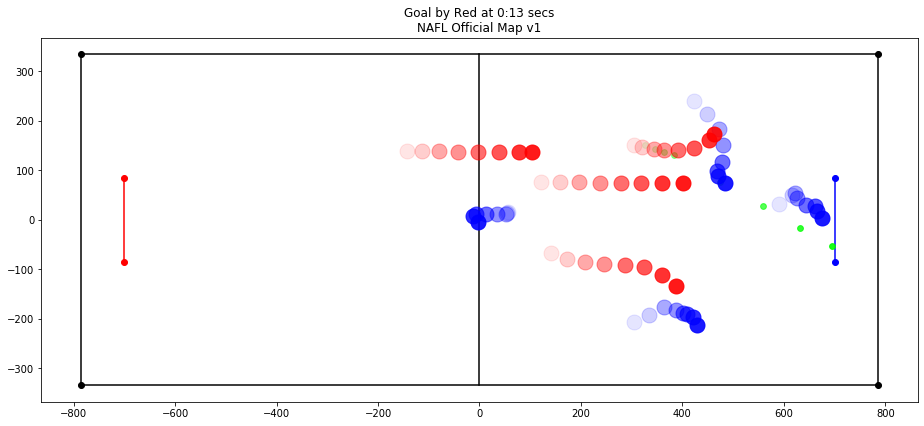

In [12]:
offset = 2
show_trail = True
goals = df.query("ag == 1").to_dict(orient="records")
goal = goals[0]
if show_trail:
    before_goal = get_positions_in_range(match["positions"], goal["time"] - offset, goal["time"])
else:
    before_goal = get_positions_at_time(match["positions"], goal["time"] - offset)
fig, ax = plot_positions(before_goal, stadium)
w, h = zoom_stadium(stadium["bounds"])
goal_team = "Red" if goal["team"] == "red" else "Blue"
goal_clock = to_clock(goal["time"])
title = "Goal by {} at {} secs\n{}".format(goal_team, goal_clock, stadium["stadium"])
ax.set_title(title)
fig.set_size_inches(w, h)
# add 18yrd box
fig

The next step is to take the data from the frame before the kick and quantify defender positioning, like distance between defender in ball, number of defenders in the goal area, and other heuristics.

Write a method that takes in a match and stadium and produces the new features, then we can easily integrate it into the model training process.

In [26]:
def defender_feature(positions,kick):
    """
    For a given kick, find the closests defender and the number of defenders within 200 dist
    """
    ret = [0,0]
    closest_defender = float('inf')
    defenders_pressuring = 0
    for person in positions:
        if person['team'] is not kick['fromTeam'] and person['type'] is "player": 
            defender_dist = ((kick['fromX'] - person['x'])**2 + (kick['fromY'] - person['y'])**2)**(1/2) # distance formula
            if defender_dist < closest_defender:
                closest_defender = defender_dist
                ret[0] = closest_defender
            if defender_dist <= 200:
                defenders_pressuring = defenders_pressuring + 1
                ret[1] = defenders_pressuring
    return ret

In [27]:
def get_defender_features(match):
    """
    Args:
        match: index for match within metadata
    Returns:
        Return a df containing new features of closest defender and defenders pressuring kick(within 200 dist)
    """
    meta = get_matches_metadata("../data/matches_metadata.csv")[match]
    stadiums = get_stadiums("../data/stadiums.json")
    infile = "../data/packed_matches/{}.json".format(meta["match_id"])
    stadium = stadiums[meta["stadium"]]
    match = load_match(infile)
    row_gen = generate_rows_demo(match, stadium)
    df = pd.DataFrame(row_gen)
    kick_df = pd.DataFrame(match["kicks"]).to_dict(orient="records")
    closest_defender = []
    defender_within = []
    for kick in kick_df:
        positions = get_positions_at_time(match["positions"], kick["time"])
        closest_defender.append(defender_feature(positions,kick)[0])
        defender_within.append(defender_feature(positions,kick)[1])
    df["closestDefnder"] = closest_defender
    df["defenderWithinDist"] = defender_within # TODO: maybe defenders infront of box
    return df

In [28]:
new_df = get_defender_features(543)
new_df

,ag,index,time,x,y,goal_x,goal_y,goal_distance,goal_angle,team,stadium,closestDefnder,defenderWithinDist
0,0,0,2.3,-12.0,15.0,700,0,712.157988,1.549732,red,NAFL Official Map v1,280.862956,0
1,0,1,6.0,281.0,-108.0,-700,0,986.927049,1.461146,blue,NAFL Official Map v1,277.308492,0
2,0,2,7.3,21.0,-276.0,-700,0,772.021373,1.205203,blue,NAFL Official Map v1,79.649231,2
3,0,3,11.3,401.0,106.0,-700,0,1106.090864,1.474816,blue,NAFL Official Map v1,131.308796,1
4,1,4,13.3,364.0,142.0,700,0,364.773903,1.170944,red,NAFL Official Map v1,137.437258,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0,117,233.6,-609.0,-272.0,-700,0,286.818758,0.322853,blue,NAFL Official Map v1,38.118237,2
118,0,118,235.3,-644.0,-216.0,700,0,1361.246488,1.411445,red,NAFL Official Map v1,89.140339,1
119,0,119,235.3,-503.0,-115.0,700,0,1208.484174,1.475492,red,NAFL Official Map v1,109.178753,1
120,0,120,237.8,-459.0,-116.0,-700,0,267.464016,1.122198,blue,NAFL Official Map v1,167.355908,2


## Next, train model with new features and see how well it does.